In [38]:
import os
import rasterio
from rasterio.plot import show
from rasterio.features import shapes
import numpy as np
import matplotlib.pyplot as plt



In [39]:
my_image = rasterio.open('clipped.tif')

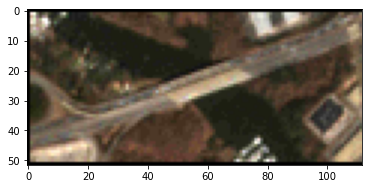

<AxesSubplot:>

In [40]:
show(my_image.read())

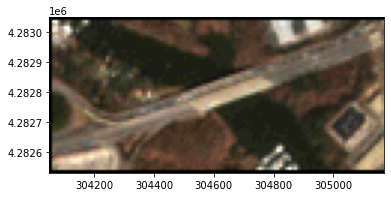

EPSG:32618


In [41]:
show(my_image.read(), transform=my_image.transform) # raster coordinates to actual coordinates 
print(my_image.crs)

In [42]:
red = my_image.read(1)
green = my_image.read(2)
blue = my_image.read(3)
red

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 253, 252, ..., 100,  92, 136],
       [  0, 208, 204, ..., 125, 125, 150],
       ...,
       [  0, 173, 165, ..., 189, 165, 133],
       [  0, 145, 151, ..., 145, 133, 116],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [43]:
red = np.float32(red)
green = np.float32(green)
blue = np.float32(blue)
red

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 253., 252., ..., 100.,  92., 136.],
       [  0., 208., 204., ..., 125., 125., 150.],
       ...,
       [  0., 173., 165., ..., 189., 165., 133.],
       [  0., 145., 151., ..., 145., 133., 116.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)

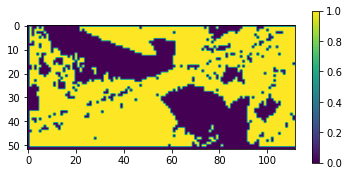

In [44]:
# Create a new empty numpy array of zeros.#
water_index = np.zeros(blue.shape)

# Now let's allocate values to our water index
# Where red is larger than green, we will apply 1
water_index[(red > green)] = 1

plt.imshow(water_index)
plt.colorbar(shrink=0.7)

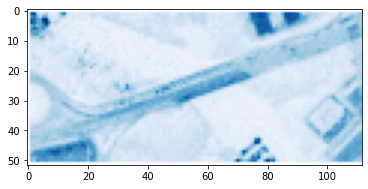

<AxesSubplot:>

In [45]:
show(blue, cmap='Blues')

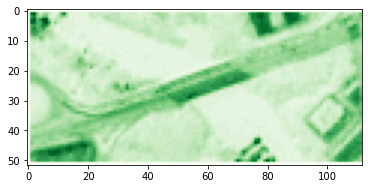

<AxesSubplot:>

In [46]:
# Plot the green band
show(green, cmap='Greens')

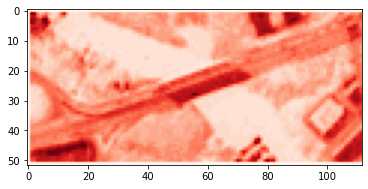

<AxesSubplot:>

In [47]:
# Plot the red band
show(red, cmap='Reds')

In [48]:
#change data type
red = np.float32(red)
green = np.float32(green)
blue = np.float32(blue)
red

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 253., 252., ..., 100.,  92., 136.],
       [  0., 208., 204., ..., 125., 125., 150.],
       ...,
       [  0., 173., 165., ..., 189., 165., 133.],
       [  0., 145., 151., ..., 145., 133., 116.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)

In [49]:
# Convert from float64 to float32 first
water_index = water_index.astype('float32')

# Now convert the numpy array to geojson
my_shapes = shapes(water_index)

# Let's inspect the first geojson
# When we reach the break command the loop ceases
# Thus, only the first is printed.
for my_shape in my_shapes:
    print(my_shape)
    break 

({'type': 'Polygon', 'coordinates': [[(79.0, 1.0), (79.0, 2.0), (80.0, 2.0), (80.0, 1.0), (79.0, 1.0)]]}, 1.0)


In [50]:
# Define our desired folder name
output_folder = 'shapes'

# Now let's check if the path exists
if not os.path.exists(output_folder):
    os.mkdir(output_folder) # If not, then make the directory

In [51]:
def transform_coordinates(pair):
    """
    This function takes a pair of raster coordinates 
    and returns the geographic coordinates. 
    
    """
    geographic_coordinates = my_image.xy(pair[1],pair[0])
    
    return geographic_coordinates

In [52]:
for river in my_shapes:
    
    # Print the original coordinates for the raster
    print('These are the original raster coordinates:')
    print(river[0]['coordinates'])
    print('--')
    
    # Transform the coordinate into geographic ones
    # This is a list comprehension which feeds each pair of coordinate to our function
    coordinates = [transform_coordinates(pair) for pair in river[0]['coordinates'][0]]
    
    # Now we can inspect the difference after the transformation
    print('Whereas these are the transformed geographic coordinates:')
    print(coordinates)
    
    break

These are the original raster coordinates:
[[(100.0, 2.0), (100.0, 3.0), (101.0, 3.0), (101.0, 2.0), (100.0, 2.0)]]
--
Whereas these are the transformed geographic coordinates:
[(305055.0, 4283025.0), (305055.0, 4283015.0), (305065.0, 4283015.0), (305065.0, 4283025.0), (305055.0, 4283025.0)]


In [53]:
# Install geopandas
import sys
!conda install --yes --prefix {sys.prefix} geopandas

Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda





# All requested packages already installed.



In [54]:
# Create an empty dataframe 
output = []

# Iterate over our shapes
for river_shape in my_shapes:

    # Index into our shape to get the coordinates
    # This indexing means we access:
    # - The first list in `river_shape` via [0]
    # - The coordinates values in the dictionary via ['coordinates']
    # - The first list in `coordinates` via [0]
    coords = river_shape[0]['coordinates'][0]
    print(coords)
    # Transform the raster coordinates into geographic coordinates
    geographic_coords = [transform_coordinates(pair) for pair in coords]

    # Specify a geojson with our transformed coordinates
    output.append({
        'geometry' : {
            'type':'LineString',
            'coordinates': geographic_coords
            },
        'properties': {},
    }) 
        
print('Output contains {} shapes'.format(len(output)))

[(7.0, 3.0), (7.0, 4.0), (8.0, 4.0), (8.0, 3.0), (7.0, 3.0)]
[(61.0, 3.0), (61.0, 4.0), (62.0, 4.0), (62.0, 3.0), (61.0, 3.0)]
[(104.0, 3.0), (104.0, 4.0), (107.0, 4.0), (107.0, 3.0), (104.0, 3.0)]
[(95.0, 4.0), (95.0, 5.0), (96.0, 5.0), (96.0, 4.0), (95.0, 4.0)]
[(4.0, 3.0), (4.0, 4.0), (6.0, 4.0), (6.0, 5.0), (7.0, 5.0), (7.0, 6.0), (8.0, 6.0), (8.0, 4.0), (7.0, 4.0), (7.0, 3.0), (4.0, 3.0)]
[(5.0, 5.0), (5.0, 6.0), (6.0, 6.0), (6.0, 5.0), (5.0, 5.0)]
[(96.0, 5.0), (96.0, 6.0), (97.0, 6.0), (97.0, 5.0), (96.0, 5.0)]
[(75.0, 6.0), (75.0, 7.0), (76.0, 7.0), (76.0, 6.0), (75.0, 6.0)]
[(101.0, 4.0), (102.0, 4.0), (102.0, 5.0), (103.0, 5.0), (103.0, 6.0), (102.0, 6.0), (102.0, 7.0), (100.0, 7.0), (100.0, 6.0), (101.0, 6.0), (101.0, 4.0)]
[(77.0, 7.0), (77.0, 8.0), (78.0, 8.0), (78.0, 7.0), (77.0, 7.0)]
[(97.0, 7.0), (97.0, 9.0), (98.0, 9.0), (98.0, 8.0), (99.0, 8.0), (99.0, 7.0), (97.0, 7.0)]
[(5.0, 8.0), (5.0, 10.0), (6.0, 10.0), (6.0, 8.0), (5.0, 8.0)]
[(95.0, 8.0), (95.0, 9.0), (96.0, 

In [55]:
import geopandas

data_to_write = geopandas.GeoDataFrame.from_features(output, crs='epsg:4326')

data_to_write.to_file('shapes/river_shape.shp')

OSError: could not find or load spatialindex_c-64.dll